# HGF Modeling of PRL Data for Max's Psychedelics Disseration

# Setup 

## Get correct packages and dependencies and read in Peter's HGF script
Make sure you have the Project and Manifest.toml in your current directory

In [ ]:
### Initialize Environment and instantiate based on .toml
import Pkg
cd("C:/Users/maxsu/DataAnalysis/julia_hgf") #cd to directory with the correct project.toml and manifest.toml
Pkg.activate(".") #activate environment in current directory (assuming we're in above directory)
Pkg.instantiate() #ensures all correct packages and dependencies in .tomls are installed
# include("create_hgf.jl")  # Use all of the functions and whatnot that Peter created

### Load libraries
using HierarchicalGaussianFiltering
using ActionModels
using StatsPlots
using Distributions
using Turing
using CSV
using DataFrames
using Plots


In [ ]:
### READ IN AND REFORMAT DATA ###
df = DataFrame(CSV.File("./Data/prl_julia.csv"))

#Get list of participant ids
unique_values = unique(df.record_id)
println("Unique record_id values: ", unique_values)

participant = 60

#select the inputs for other participants
df_inputs_participant = df[df.record_id .== participant, ["fractal1HGF", "fractal2HGF", "fractal3HGF"]] #MUST BE IN THIS ORDER FOR XPROB TO LINE UP WITH BANDITS!

#select the observations for the action model
df_obs_participant = df[df.record_id .== participant, ["fractalselected", "outcome"]]

#Also get whole dataset for just one participant
df_participant = df[df.record_id .== participant,:]

#select the reward probabilities for simulated_actions
df_probs_participant = df[df.record_id .== participant, ["rewardProbFractal1", "rewardProbFractal2", "rewardProbFractal3"]]





# Create HGF and Agent

In [ ]:
######## CREATE HGF ######
config = Dict()

#Defaults
spec_defaults = Dict(
    "n_bandits" => 3,

    ("xprob", "volatility") => -2,
    ("xprob", "drift") => 0,
    ("xprob", "autoconnection_strength") => 1,
    ("xprob", "initial_mean") => 0,
    ("xprob", "initial_precision") => 1,

    ("xvol", "volatility") => -2,
    ("xvol", "drift") => 0,
    ("xvol", "autoconnection_strength") => 1,
    ("xvol", "initial_mean") => 0,
    ("xvol", "initial_precision") => 1,

    ("xbin", "xprob", "coupling_strength") => 1,
    ("xprob", "xvol", "coupling_strength") => 1,

    "update_type" => EnhancedUpdate(),
    "save_history" => true,
)

#Merge to overwrite defaults
config = merge(spec_defaults, config)

#Initialize list of nodes
nodes = HierarchicalGaussianFiltering.AbstractNodeInfo[]
edges = Dict{Tuple{String, String}, HierarchicalGaussianFiltering.CouplingType}()
grouped_xprob_volatility = []
grouped_xprob_drift = []
grouped_xprob_autoconnection_strength = []
grouped_xprob_initial_mean = []
grouped_xprob_initial_precision = []
grouped_xbin_xprob_coupling_strength = []
grouped_xprob_xvol_coupling_strength = []

#For each bandit
for i = 1:config["n_bandits"]

    #Add input node
    push!(nodes, BinaryInput("u$i"))

    #Add binary node
    push!(nodes, BinaryState("xbin$i"))

    #Add probability node
    push!(
        nodes,
        ContinuousState(
            name = "xprob$i",
            volatility = config[("xprob", "volatility")],
            drift = config[("xprob", "drift")],
            autoconnection_strength = config[("xprob", "autoconnection_strength")],
            initial_mean = config[("xprob", "initial_mean")],
            initial_precision = config[("xprob", "initial_precision")],
        ),
    )

    #Group the parameters for each binary HGF
    push!(grouped_xprob_volatility, ("xprob$i", "volatility"))
    push!(grouped_xprob_drift, ("xprob$i", "drift"))
    push!(grouped_xprob_autoconnection_strength, ("xprob$i", "autoconnection_strength"))
    push!(grouped_xprob_initial_mean, ("xprob$i", "initial_mean"))
    push!(grouped_xprob_initial_precision, ("xprob$i", "initial_precision"))
    push!(grouped_xbin_xprob_coupling_strength, ("xbin$i", "xprob$i", "coupling_strength"))
    push!(grouped_xprob_xvol_coupling_strength, ("xprob$i", "xvol", "coupling_strength"))

    #Add edges
    push!(edges, ("u$i", "xbin$i") => ObservationCoupling())
    push!(
        edges,
        ("xbin$i", "xprob$i") =>
            ProbabilityCoupling(config[("xbin", "xprob", "coupling_strength")]),
    )
    push!(
        edges,
        ("xprob$i", "xvol") =>
            VolatilityCoupling(config[("xprob", "xvol", "coupling_strength")]),
    )

end

#Add the shared volatility parent
push!(
    nodes,
    ContinuousState(
        name = "xvol",
        volatility = config[("xvol", "volatility")],
        drift = config[("xvol", "drift")],
        autoconnection_strength = config[("xvol", "autoconnection_strength")],
        initial_mean = config[("xvol", "initial_mean")],
        initial_precision = config[("xvol", "initial_precision")],
    ),
)

parameter_groups = [

    ParameterGroup("xprob_volatility",
        grouped_xprob_volatility,
        config[("xvol", "volatility")],
    ),
    ParameterGroup("xprob_drift",
        grouped_xprob_drift,
        config[("xvol", "drift")],
    ),
    ParameterGroup("xprob_autoconnection_strength",
        grouped_xprob_autoconnection_strength,
        config[("xvol", "autoconnection_strength")],
    ),
    ParameterGroup("xprob_initial_mean",
        grouped_xprob_initial_mean,
        config[("xvol", "initial_mean")],
    ),
    ParameterGroup("xprob_initial_precision",
        grouped_xprob_initial_precision,
        config[("xvol", "initial_precision")],
    ),
    ParameterGroup("xbin_xprob_coupling_strength",
        grouped_xbin_xprob_coupling_strength,
        config[("xbin", "xprob", "coupling_strength")],
    ),
    ParameterGroup("xprob_xvol_coupling_strength",
        grouped_xprob_xvol_coupling_strength,
        config[("xprob", "xvol", "coupling_strength")],
    ),
]

#Initialize the HGF
hgf = init_hgf(
    nodes = nodes,
    edges = edges,
    parameter_groups = parameter_groups,
    verbose = false,
    node_defaults = NodeDefaults(update_type = config["update_type"]),
    save_history = config["save_history"],
)

### CREATE AGENT ###

#Softmax function
function softmax(x::AbstractVector, inv_temp::Real)
    exp_values = exp.(x * inv_temp)
    prob_values = exp_values / sum(exp_values)
    return prob_values
end

#Action model function
function choose_bandit(agent::Agent, input::Any)

    ### UPDATE HGF ###
    #Unpack the input into which badnit has been observed, and what the observation was
    observed_bandit, observation = input

    #Extrat the HGF
    hgf = agent.substruct

    #Create empty vector of observations
    hgf_input = Vector{Union{Int, Missing}}(missing, length(hgf.input_nodes))

    #Change the missing to the atual observation for the bandit that was observed
    hgf_input[observed_bandit] = observation

    #Pass the observation to the HGF
    update_hgf!(hgf, hgf_input)


    ### PICK A BANDIT ###   
    #Get the predicted probabilites for reqards for each of the bandits
    predicted_probabilities = [hgf.ordered_nodes.input_nodes[i].edges.observation_parents[1].states.prediction_mean for i in 1:length(hgf.input_nodes)]

    #Get the precision parameter
    β = agent.parameters["softmax_precision"]

    #Run them through the softmax
    action_proabilities = softmax(predicted_probabilities, β)

    #If the probabilities became NaN
    if any(isnan, action_proabilities)
        #Throw an error that will reject samples when fitted
        throw(
            RejectParameters(
                "With these parameters and inputs, the probabilities became NaN, which is invalid. Try other parameter settings",
            ),
        )
    end

    #Return a Categorical probability distribution
    action_distribution = Categorical(action_proabilities)

    return action_distribution
end

#Add the temeprature parmaeter for the action model
parameters = Dict("softmax_precision" => 1)

#create the agent
agent = init_agent(
    choose_bandit, 
    substruct = hgf,
    parameters = parameters
)


# ### PLAY WITH THE AGENT ###

# #See the parameters in the agent
# get_parameters(agent)

# #Set parameters
# set_parameters!(agent, Dict("softmax_precision" => 0.1))
# reset!(agent)

# #"real inputs"
# inputs = [
#     [1, 1],
#     [2, 0],
#     [3, 1],
#     [1, 0],
#     [2, 1],
# ]

# #Run forward to simulate actions
# simulated_actions = give_inputs!(agent,inputs)

# #Plot belief trajectories
# plot_trajectory(agent, "xbin1")

### Optional: testing HGF and Response models separately

In [ ]:
##### TRY OUT HGF #####

## READ DATA ##
#One vector per timepoint.
#Consiting of a vector with a value for each bandit
#Which can be 0, 1 or missing (i.e. no observaiton of that bandit)
# For example: 
# inputs = [
#     [missing, 1, missing],
#     [missing, 0, missing],
#     [missing, missing, 1],
#     [missing, missing, 1],
# ]

inputs = [collect(row) for row in eachrow(df_inputs_participant)]

#See current parameter values
get_parameters(hgf)

parameters = Dict("xprob_volatility" => -1.25, #-1.28
                    #1.28 seems to be the best number; 1.27-1.28. Cannot be estimated above -1.26, and bad xvol below -1.3
                "xprob_initial_mean" => 0,
                "xbin_xprob_coupling_strength" => 1,
                    #can't really go over 1
                "xprob_xvol_coupling_strength" => 1, 
                    #increasing when xprob_vol low (causing low xvol) leads to flat xprob. 
                    #When xprob_vol high, higher levels flatten both xprob AND xvol. 
                    #decreasing to 0.2 flattens xvol and sorta xprob
                "xprob_drift" => 0,
                    # Cannot really change much w/o model freaking out
                "xprob_autoconnection_strength" => 0.95, 
                    # HUGE effects from changes -- best range is 0.95 - 1.01.
                    # Seems like 1 = not autoconnection, <1 = increasing regression to 0.5, >1 = increasing regression AWAY from 0.5 (lower if last estimate was <0.5; higher if >0.5)
                    # Cannot go far above 1!!!
                )

#Change parameter values
set_parameters!(hgf, parameters)
reset!(hgf)

#Give inputs to the HGF
give_inputs!(hgf, inputs)

# Plot  belief trajectory for the HGF w/actual reward probabilities overlayed

# #but first adjust the reward probabilities to be roughly the min and max for the xprobabilities
# df_60_graphing = df_60
# cols = names(df_60_graphing)  # Targeting all columns for replacement
# for col in cols
#     df_60_graphing[!, col] = map(x -> begin
#         if ismissing(x)
#             x  # Keep missing values as missing
#         else
#             if x == 0.15 #min prob
#                 -4.5
#             elseif x == 0.85 #max probability
#                 4.5 #max xprob
#             elseif x == 1
#                 4.3
#             elseif x == 0 #if loss, make dot show up at bottom
#                 -4.3
#             elseif x == 0.5 #50% probabilitiy should be 0 center of graph
#                 0.001
#             else
#                 x  # Return x unchanged if none of the conditions are met
#             end
#         end
#     end, df_60_graphing[!, col])
# end

#Add colors array for graphing wins vs. losses
colors3 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_participant.fractal3HGF]
colors2 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_participant.fractal2HGF]
colors1 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_participant.fractal1HGF]

xvol_plot = plot_trajectory(hgf,"xvol")

xprob3_plot = plot_trajectory(hgf, "xbin3")
plot!(xprob3_plot, df_participant.trial, df_participant.rewardProbFractal3, label="Bandit 3 true rew prob", color=:blue, linewidth=3)
scatter!(xprob3_plot, df_participant.trial, df_participant.fractal3HGF, label="Bandit 3 observations", color=colors3)

xprob2_plot = plot_trajectory(hgf, "xbin2")
plot!(xprob2_plot, df_participant.trial, df_participant.rewardProbFractal2, label="Bandit 2 true rew prob", color=:blue, linewidth=3)
scatter!(xprob2_plot, df_participant.trial, df_participant.fractal2HGF, label="Bandit 2 observations", color=colors2)

xprob1_plot = plot_trajectory(hgf, "xbin1")
plot!(xprob1_plot, df_participant.trial, df_participant.rewardProbFractal1, label="Bandit 1 true rew prob", color=:blue, linewidth=3)
scatter!(xprob1_plot, df_participant.trial, df_participant.fractal1HGF, label="Bandit 1 observations", color=colors1)


# Combine all plots into a single figure with a specified layout
combined_plot = plot(xvol_plot, xprob3_plot, xprob2_plot, xprob1_plot, layout = (4,1), size = (1500,800), legend=false)

# Display the combined plot
display(combined_plot)

# savefig(combined_plot, "./visualizations/HGFtrajectories_id60.png")  # Saves the plot as a PNG file



# plot_trajectory!(hgf, "xprob2")
# plot_trajectory!(hgf, "xvol3")

# plot(
#     xprob3_plot=plot_trajectory(hgf, "xprob3"), # reward probability for 3rd fractal
#     plot!(xprob3_plot, df_60.trial, df_60.rewardProbFractal3, label="Bandit 3", color=:red,linewidth=3)

#     xprob2_plot=plot_trajectory(hgf, "xprob2"), # reward probability for 2nd  fractal
#     plot!(xprob2_plot, df_60.trial, df_60.rewardProbFractal2, label="Bandit 2", color=:blue, linewidth=3)

#     xprob1_plot=plot_trajectory(hgf, "xprob1"), # reward probability for 1st fractal
#     plot!(xprob1_plot,df_60.trial, df_60.rewardProbFractal1, label="Bandit 1", color=:green, linewidth=3)
#     layout = (3,1), #3 rows 1 column
#     size = (1500,800),
#     legend=false,
# )





In [ ]:
### TEST AGENT ###

#See the parameters in the agent
get_parameters(agent)

#Set parameters
set_parameters!(agent, Dict("softmax_temperature" => 100000000000))
reset!(agent)


# #"real inputs" [banditSelected,outcome]
# inputs = [
#     [1, 1],
#     [2, 0],
#     [3, 1],
#     [1, 0],
#     [2, 1],
    
# ]

inputs = [Int.(collect(row)) for row in eachrow(df_obs_60)] #need to convert float to integer

#Run forward to simulate actions
simulated_actions = give_inputs!(agent,inputs)

#Plot belief trajectories
xvol_plot = plot_trajectory(agent,"xvol")

xprob3_plot = plot_trajectory(agent, "xbin3")
plot!(xprob3_plot, df_60.trial, df_60.rewardProbFractal3, label="Bandit 3 true rew prob", color=:blue, linewidth=3)
scatter!(xprob3_plot, df_60.trial, df_60.fractal3HGF, label="Bandit 3 observations", color=colors3)

xprob2_plot = plot_trajectory(agent, "xbin2")
plot!(xprob2_plot, df_60.trial, df_60.rewardProbFractal2, label="Bandit 2 true rew prob", color=:blue, linewidth=3)
scatter!(xprob2_plot, df_60.trial, df_60.fractal2HGF, label="Bandit 2 observations", color=colors2)

xprob1_plot = plot_trajectory(agent, "xbin1")
plot!(xprob1_plot, df_60.trial, df_60.rewardProbFractal1, label="Bandit 1 true rew prob", color=:blue, linewidth=3)
scatter!(xprob1_plot, df_60.trial, df_60.fractal1HGF, label="Bandit 1 observations", color=colors1)


# Combine all plots into a single figure with a specified layout
combined_plot = plot(xvol_plot, xprob3_plot, xprob2_plot, xprob1_plot, layout = (4,1), size = (1500,800), legend=false)

# Display the combined plot
display(combined_plot)


#### SIMULARTING TO SEE WAHT HAPPENS WITH DIFFERENT PARAMETER SETTINGS ####

#Set true probs
true_probs = [0.1, 0.1, 0.9]
#Set initial choice
init_choice = rand(Categorical([1/3, 1/3, 1/3]))
initial_obs = rand(Bernoulli(true_probs[init_choice]))
next_input = (init_choice,initial_obs)
#Set agent parameters
set_parameters!(agent, Dict("softmax_precision" => 4,
                            "xprob_volatility" => -2,))
reset!(agent)

#Save the inputs
inputs = []
simulated_actions = []

push!(inputs, next_input)
#Simulate
for i = 1:100
    #Update HGF and generate action
    action = single_input!(agent, next_input)

    #generate new observation based on action
    new_observation = rand(Bernoulli(true_probs[action]))

    #Save the next input as the action and the observation
    next_input = (action, new_observation)

    push!(simulated_actions, action)
    push!(inputs, next_input)
end

#remove the last input
pop!(inputs)

#Plot
plot_trajectory(agent, "action")
plot_trajectory(agent, "xbin1")
plot_trajectory(agent, "xbin2")
plot_trajectory(agent, "action")

# length(inputs)
# length(simulated_actions)



# Simulation

In [ ]:
#Get list of participant ids
unique_values = unique(df.record_id)


participant = 84

#select the inputs for other participants
df_inputs_participant = df[df.record_id .== participant, ["fractal1HGF", "fractal2HGF", "fractal3HGF"]] #MUST BE IN THIS ORDER FOR XPROB TO LINE UP WITH BANDITS!

#select the observations for the action model
df_obs_participant = df[df.record_id .== participant, ["fractalselected", "outcome"]]

#Also get whole dataset for just one participant
df_participant = df[df.record_id .== participant,:]

# #select the reward probabilities for simulated_actions
df_probs_participant = df[df.record_id .== participant, ["rewardProbFractal1", "rewardProbFractal2", "rewardProbFractal3"]]
println("Unique record_id values: ", unique_values)

### Simulate Actions/Inputs based on RewardProbs/Parameters

┌ Warning: Indices Base.OneTo(259) of attribute `seriescolor` does not match data indices 5:257.
└ @ Plots C:\Users\maxsu\.julia\packages\Plots\7R93Y\src\utils.jl:141
┌ Info: Data contains NaNs or missing values, and indices of `seriescolor` vector do not match data indices.
│ If you intend elements of `seriescolor` to apply to individual NaN-separated segments in the data,
│ pass each segment in a separate vector instead, and use a row vector for `seriescolor`. Legend entries
│ may be suppressed by passing an empty label.
│ For example,
│     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], seriescolor=[1 2])
└ @ Plots C:\Users\maxsu\.julia\packages\Plots\7R93Y\src\utils.jl:143
┌ Warning: Indices Base.OneTo(259) of attribute `linecolor` does not match data indices 5:257.
└ @ Plots C:\Users\maxsu\.julia\packages\Plots\7R93Y\src\utils.jl:141
┌ Info: Data contains NaNs or missing values, and indices of `linecolor` vector do not match data indices.
│ If you intend elements of `linecolor` 

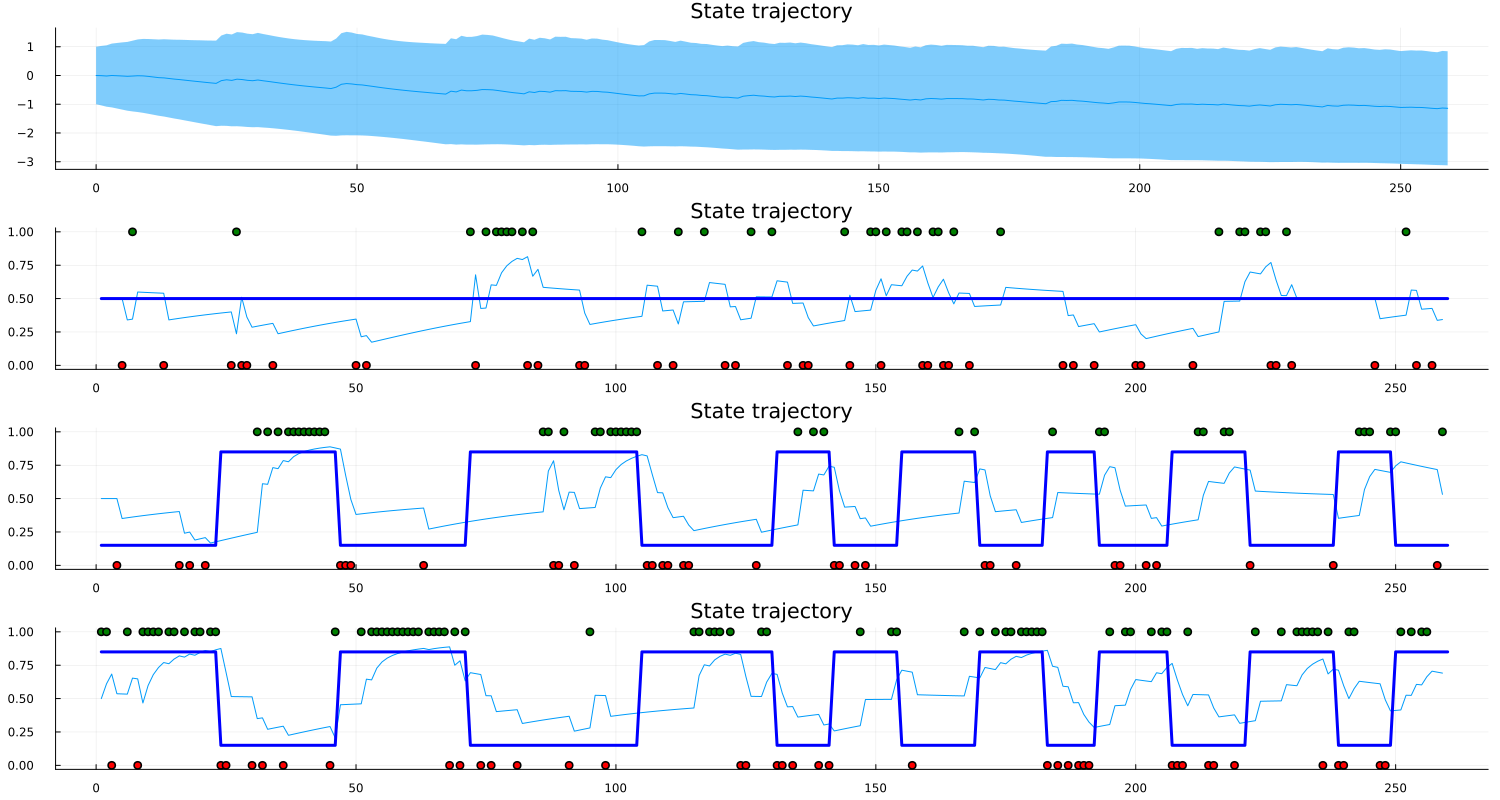

In [65]:
#### SIMULARTING TO SEE WHAT HAPPENS WITH DIFFERENT PARAMETER SETTINGS ####



#Set true probs
true_probs = [collect(row) for row in eachrow(df_probs_participant)] #need to convert float to integer


#Set initial choice
init_choice = rand(Categorical([1/3, 1/3, 1/3]))
initial_obs = rand(Bernoulli(true_probs[1][init_choice]))
next_input = (init_choice,initial_obs)
#Set agent parameters
set_parameters!(agent, Dict("softmax_precision" => 4, # 4 seems to work well... 5 is maybe too high? 
                            # "xvol_volatility" => -2,
                            #default = -2
                            "xprob_volatility" => -1.5,
                            #default = -2
                            #-1.28 seems to be the best number; 1.27-1.28. Cannot be estimated above -1.26, and bad xvol below -1.3
                            "xbin_xprob_coupling_strength" => 1,
                            "xprob_initial_mean" => 0,
                            "xprob_xvol_coupling_strength" => 1, 
                            #initial = 1
                            #increasing when xprob_vol low (causing low xvol) leads to flat xprob. 
                            #When xprob_vol high, higher levels flatten both xprob AND xvol. 
                            #decreasing to 0.2 flattens xvol and sorta xprob
                            "xprob_drift" => 0,
                            # Cannot really change much w/o model freaking out
                            "xprob_autoconnection_strength" => 0.96, 
                            # HUGE effects from changes -- best range is 0.95 - 1.01.
                            # Seems like 1 = not autoconnection, <1 = increasing regression to 0.5, >1 = increasing regression AWAY from 0.5 (lower if last estimate was <0.5; higher if >0.5)
                            # Cannot go far above 1!!!

                            ))
reset!(agent)

#Save the inputs
inputs = []
simulated_actions = []

push!(inputs, next_input)

#Simulate
for i = 2:length(true_probs) ##start at trial 2 (since trial 1 is random),and go to the length of the total trials


    #Update HGF and generate action
    action = single_input!(agent, next_input)

    #generate new observation based on action
    new_observation = rand(Bernoulli(true_probs[i][action]))

    #Save the next input as the action and the observation
    next_input = (action, new_observation)

    push!(simulated_actions, action)
    push!(inputs, next_input)
end

#remove the last input
pop!(inputs)

## Get the trials on which the bandit was selected for later graphing

# Create an empty DataFrame of length inputs that's all missing for the fractal reward or punishment
df_actions = DataFrame(
    trial = 1:length(inputs), 
    fractal1HGF = Vector{Union{Missing, Int}}(missing, length(inputs)),
    fractal2HGF = Vector{Union{Missing, Int}}(missing, length(inputs)),
    fractal3HGF = Vector{Union{Missing, Int}}(missing, length(inputs))
)


# Populate the DataFrame based on inputs
for (index, (action, result)) in enumerate(inputs)
    # Convert true/false to 1/0
    result_value = result ? 1 : 0
    
    # Determine which fractal column to update
    if action == 1
        df_actions.fractal1HGF[index] = result_value
    elseif action == 2
        df_actions.fractal2HGF[index] = result_value
    elseif action == 3
        df_actions.fractal3HGF[index] = result_value
    end
end

# Add colors for the losses vs. rewards
colors3 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_actions.fractal3HGF]
colors2 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_actions.fractal2HGF]
colors1 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_actions.fractal1HGF]


#Plot belief trajectories
xvol_plot = plot_trajectory(agent,"xvol")

# action_plot = plot_trajectory(agent,"action")

xprob3_plot = plot_trajectory(agent, "xbin3")
plot!(xprob3_plot, df_participant.trial, df_participant.rewardProbFractal3, label="Bandit 3 true rew prob", color=:blue, linewidth=3)
scatter!(xprob3_plot, df_actions.trial, df_actions.fractal3HGF, label="Bandit 3 observations", color=colors3)

xprob2_plot = plot_trajectory(agent, "xbin2")
plot!(xprob2_plot, df_participant.trial, df_participant.rewardProbFractal2, label="Bandit 2 true rew prob", color=:blue, linewidth=3)
scatter!(xprob2_plot, df_actions.trial, df_actions.fractal2HGF, label="Bandit 2 observations", color=colors2)

xprob1_plot = plot_trajectory(agent, "xbin1")
plot!(xprob1_plot, df_participant.trial, df_participant.rewardProbFractal1, label="Bandit 1 true rew prob", color=:blue, linewidth=3)
scatter!(xprob1_plot, df_actions.trial, df_actions.fractal1HGF, label="Bandit 1 observations", color=colors1)


# Combine all plots into a single figure with a specified layout
combined_plot = plot(xvol_plot, xprob3_plot, xprob2_plot, xprob1_plot, layout = (4,1), size = (1500,800), legend=false)

# Display the combined plot
display(combined_plot)

# savefig(combined_plot, "./visualizations/HGFtrajectories_id60.png")  # Saves the plot as a PNG file

# #Plot
# plot_trajectory(agent, "xvol")
# plot_trajectory(agent, "action")
# plot_trajectory(agent, "xbin1")
# plot_trajectory(agent, "xbin2")
# plot_trajectory(agent, "xbin3")

In [59]:
# get_history(agent, ("action"))
inputs

259-element Vector{Any}:
 (2, false)
 (3, true)
 (3, true)
 (3, false)
 (1, true)
 (2, false)
 (3, true)
 (1, true)
 (2, false)
 (3, true)
 ⋮
 (2, false)
 (2, false)
 (3, false)
 (3, false)
 (2, false)
 (2, false)
 (1, false)
 (1, true)
 (3, true)

# Parameter Estimation

### Estimate Parameters for all participants

### Estimate parameters for one participant

In [ ]:
### PARAMETER ESTIMATION FOR SINGLE PARTICIPANT ###

#agent should already be defined above

#Set prior distributions for each parameter THAT WE WANT TO ESTIMATE!!!!!!!!!!!!!!! 
#Otherwise, priors fixed to their DEFAULTS in the "create HGF"!!
#the 1st # = mean, 2nd = SD
#lower = lower bound; upper = upper bound -- but will need to include "truncated"!!! 
priors = Dict(
    "softmax_precision" => truncated(Normal(5, 2),  lower = 0), 
    "xvol_volatility" => Normal(-2,1),

    ##more xvol here...
    "xprob_xvol_coupling_strength" => 1, 
    "xprob_initial_mean" => Normal(0,1),
    "xprob_volatility" => Normal(-4, 1),
    "xprob_drift" => 0,
    "xprob_autoconnection_strength" => 1, 
    ##more xprob here...
    "xbin_xprob_coupling_strength" => 1,

)

results = fit_model(agent, 
                    priors, 
                    inputs, 
                    simulated_actions;
                    sampler = NUTS(),
                    n_iterations = 1000,
                    n_chains = 2)

plot(results)

#Plot the posterior distribution against the prior distribution; if your prior is set differently from the true parameter, then you'd hope to see divergence between prior and posterior!
plot_parameter_distribution(results, priors)

get_posteriors(results)

## Graveyard code


In [ ]:
# #but first adjust the reward probabilities to be roughly the min and max for the xprobabilities
# df_60_graphing = df_60
# cols = names(df_60_graphing)  # Targeting all columns for replacement
# for col in cols
#     df_60_graphing[!, col] = map(x -> begin
#         if ismissing(x)
#             x  # Keep missing values as missing
#         else
#             if x == 0.15 #min prob
#                 -4.5
#             elseif x == 0.85 #max probability
#                 4.5 #max xprob
#             elseif x == 1
#                 4.3
#             elseif x == 0 #if loss, make dot show up at bottom
#                 -4.3
#             elseif x == 0.5 #50% probabilitiy should be 0 center of graph
#                 0.001
#             else
#                 x  # Return x unchanged if none of the conditions are met
#             end
#         end
#     end, df_60_graphing[!, col])
# end

# #Add colors array for graphing wins vs. losses
# colors3 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_60_graphing.fractal3HGF]
# colors2 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_60_graphing.fractal2HGF]
# colors1 = [ismissing(x) ? :black : (x > 0 ? :green : :red) for x in df_60_graphing.fractal1HGF]

# xvol_plot = plot_trajectory(hgf,"xvol")

# xprob3_plot = plot_trajectory(hgf, "xbin3")
# plot!(xprob3_plot, df_60_graphing.trial, df_60_graphing.rewardProbFractal3, label="Bandit 3 true rew prob", color=:blue, linewidth=3)
# scatter!(xprob3_plot, df_60_graphing.trial, df_60_graphing.fractal3HGF, label="Bandit 3 observations", color=colors3)

# xprob2_plot = plot_trajectory(hgf, "xbin2")
# plot!(xprob2_plot, df_60_graphing.trial, df_60_graphing.rewardProbFractal2, label="Bandit 2 true rew prob", color=:blue, linewidth=3)
# scatter!(xprob2_plot, df_60_graphing.trial, df_60_graphing.fractal2HGF, label="Bandit 2 observations", color=colors2)

# xprob1_plot = plot_trajectory(hgf, "xbin1")
# plot!(xprob1_plot, df_60_graphing.trial, df_60_graphing.rewardProbFractal1, label="Bandit 1 true rew prob", color=:blue, linewidth=3)
# scatter!(xprob1_plot, df_60_graphing.trial, df_60_graphing.fractal1HGF, label="Bandit 1 observations", color=colors1)


# # Combine all plots into a single figure with a specified layout
# combined_plot = plot(xvol_plot, xprob3_plot, xprob2_plot, xprob1_plot, layout = (4,1), size = (1500,800), legend=false)

# # Display the combined plot
# display(combined_plot)

In [ ]:
# # see what premade agents already exist
# premade_agent("help")
# #load other useful libraries
# using HGF
# using ActionModels
# using Turing
# using CSV
# using DataFrames
# using Plots
# using StatsPlots
# using LogExpFunctions
# using Colors
# using StatsModelComparisons

# Part 1: Building an analysis pipeline

## Overview: 

In this section, we'll go step-by-step through an analysis pipeline with the HGF.

For this example analysis, we will use the task (and data from one subject) from the Iglesias et al. paper described during the presentation. Link to dataset: https://www.research-collection.ethz.ch/handle/20.500.11850/454711.


Roughly, this comprises of two steps, that should be iterated:
1. Choosing (and potentially implementing) a model.
2. Model fitting and checking.

We will illustrate these steps below. First, we need to load some example data to use.



In [ ]:
# load example data
u = Bool[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0];
y = Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];


## Step 1: Choose models and priors

### Define first model: biased random

When modelling, we always want to control for alternative, simpler explanations. It might be that our subjects are dynamically updating their beliefs in accordance with our assumptions. However, sometimes, they might just be responding rather randomly and not show much learning at all. 

To control for this possibility, we define a simple alternative model below. This model just takes random actions with a single fixed probability. It does not integrate the data from the task at all. 

In [ ]:
#
# Model 1: Simple random agent with bias p 
#
function biased_random(agent::AgentStruct, input)
    #Read in parameters
    p = agent.params["probability"]
    distribution = Distributions.Bernoulli(p)
    return distribution
end
## create model
params_m1 = Dict("probability" => .2)
m1 = init_agent(biased_random, nothing, params_m1)
ysim = give_inputs!(m1, u) ##simulate responses (ysim) for agent m1 (defined above) and inupts u (which we loaded in last cell)

# look at some simulated actions
scatter(shrink(u, 1.2), legend=:outertop)
trajectory_plot!(m1, "action", label = "action")


As we can see from the plot, the actions do not really follow the pattern of the y.

Remember: the y are 1 in those trials where the high tone predicts the face vs. house image. People can follow the predictive cue, and their tendency to do so should vary with the actual tendency they have experienced so far. 

#### Check recoverability and set priors

Below, we fit the data we have simulated above, to check if we get
out the true parameter that we used to simulate the data with.

If we weren't able to do so, this would compromise the interpretability of our analysis.

In [ ]:
# try to recover parameter

# provide:
# - model : m1
# - inputs:  u
# - responses:  ysim
# - prior distributions for each parameter we want to fit: Beta(1,1)
# - the number of iterations
# - the number of MCMC chains to run 
fit = fit_model(m1, u, ysim, Dict("probability" => Beta(1,1)),
                n_iterations = 300, n_chains = 2)
plot(fit, size=(600,300))


The plots below show the results of the model fitting procedure.

* On the left: We see the "traces" of the MCMC chains. These these are chains of parameter values that were explored while the sampler moved through parameter space (exploring the posterior distribution).
  * We see two traces, one for each chain
  * We want to see them converge to the same value
  * We want the autocorrelation between iterations to be rather low 

* On the right: The posterior distribution of the "probability" parameter.
  * The two chains find similiar posteriors, as they should

We can use simulation to investigate the implications of our prior choice on the observed responses.

We use the `predictive_simulation_plot` function, providing the prior
distribution we want to use for the simulation.

The function draws parameter values for each parameter that we specified a prior for and simulates the model forward, producing responses.

Different draws lead to different responses (plus the uncertainty in the respones given the same parameters) which gives us a distribution over responses for each trial.

In [ ]:
#
# Prior predictive sim for model 1
#
priors_m1 = Dict("probability" => Beta(1,1))
predictive_simulation_plot(priors_m1, m1, u, "action", 
                                 n_simulations=100)
hline!([.5], label = "average belief")
xlabel!("trials")
ylabel!("action (0/1)")

### Define second model: RW-KF

The second model is the Kalman Filter / Rescorla-Wagner model. This
model consists of a `learning_rate` parameter and a `softmax_action_precision` (which controls the variability of responses for a certain belief).

The below code implements the belief updates for a single trial. This function will be used to define a new model for use in the `ActionModels` package. 

`new_value = old_value + learning_rate * (input - transformed_old_value)`

The agent has an internal state called `value`, which is the expected value which is updated with the above equation.


In [ ]:
#
# Model 2: RW model
#
function binary_rw_softmax(agent::AgentStruct, input)
    # Read in parameters and states
    learning_rate    = agent.params["learning_rate"]
    action_precision = agent.params["softmax_action_precision"]
    old_value        = agent.states["value"]
    # Sigmoid transform the value (transform into [0,1])
    transformed_old_value = 1 / (1 + exp(-old_value))
    # Get new value state
    new_value = old_value + learning_rate * (input - transformed_old_value)
    #Update value
    agent.states["value"] = new_value
    #Add it to history
    push!(agent.history["value"], new_value)
    push!(agent.history["prediction"], 1/(1 + exp(-new_value)))
    #Pass through softmax to get action probability
    action_probability = 1 / (1 + exp(-action_precision * new_value))
    #Create Bernoulli normal distribution with mean of the target value and a standard deviation from parameters
    distribution = Distributions.Bernoulli(action_probability)
    return distribution
end
## Create agent
params_m2 = Dict("learning_rate" => .2, "softmax_action_precision" => 0.1)
states_m2 = Dict("value" => 0, "prediction" => .5)
m2 = init_agent(binary_rw_softmax, nothing, params_m2, states_m2)
get_params(m2)
give_inputs!(m2, u)

#
# check agent looks sensible:
#
trajectory_plot(m2, "prediction", seriestype=:path)
trajectory_plot!(m2, "action")
scatter!(shrink(u, 1.2), label="inputs")
ylabel!("probability / outcome")
xlabel!("trials")


Above, we used the function `trajectory_plot` to run the model forward for a given sequence of inputs. We can see that the model's predictions adapt to the changing contingencies during the experiment. 

Try changing the parameter values in `params_m2` to see the effect.

#### Check recoverability and set priors

Below, we run a little recovery simulation to check if we get
out the true parameters that we used to simulate the data with.

For this model, as it is quite a bit more complicated than the `biased_random` model (and estimation is thus more difficult), we will simulate 10 datasets that we will fit, in order to "see through" the irreducible variability.

In [ ]:
#
# check we can recover
#

params_true = Dict("learning_rate" => .2, "softmax_action_precision" => 1)
ysim = map(1:10) do rep
  reset!(m2)
  set_params!(m2, params_true)
  give_inputs!(m2, u)
end

priors_m2 = Dict("learning_rate" => Beta(1,1),
                 "softmax_action_precision" => LogNormal(1,1))

fit = [fit_model(m2, u, y, priors_m2,
                 n_iterations = 500, n_chains = 2)
       for y in ysim]



In [ ]:
# make plots
vnames = [:learning_rate, :softmax_action_precision]

plts = map(vnames) do v
  # extract the mean of the parameter traces for each chain
  if v == vnames[end]
    leg = :outerright
    else
    leg = :none
  end
  plt = density([mean(c[v]) for c in fit], legend=leg, label="density")
  # add individual estimates as scatter
  h = ylims(plt)[2]
  scatter!([(mean(c[v]), h/4) for c in fit], label="posterior means")
  # show the true parameter (defined above)
  vline!([params_true[string(v)]], label="true value")
  title!(string(v))
  plt
end
plot(plts..., size=(700, 300))
ylabel!("density")
xlabel!("parameter value")

The results of the little recovery simulation are shown above. As you can see, we can estimate the parameters quite well.

Again, let's see the effect of different priors on the expected
distribution of actions.

For this model, we get out the simulated "belief trajectory" of the RW models for parameters sampled from the prior.

In [ ]:
#
# Prior predictive sim for model 2
#
priors_m2 = Dict("learning_rate" => LogNormal(-1,1),
                 "softmax_action_precision" => LogNormal(0,1));
predictive_simulation_plot(priors_m2, m2, u, "prediction", n_simulations=100)
xlabel!("trials")

Shown above is the prior predictive distribution over trajectories, so the distribution of trajectories trajectories simulated with parameters drawn from the prior. The individual samples are shown in grey (heavily overplotted) and their mean is shown in red.

The implication of our prior are quite uncertain, as can be seen by the coverage of the space in grey dots.

The mean trajectory is shown in red. Try changing the values in the code above.

### Define third model: HGF

We make use of the `HGF` and `ActionModels` packages to setup our HGF model. 

We could implement it as above by defining the update functions by hand, however the standard version for models are already implemented for you so we can make use of the `premade_agent` function to use them.

For the HGF, there a number of paramters that we need to choose either fixed values or prior distributions for.

As a rule, it is always best to start simple with only few parameters given priors and the rest fixed. To decide which values we should use, we can use predictive simulations. Further, we should check the recoverability of each parameter.



In [ ]:
#
# Model 3: Use standard binary 3-lvl HGF
# 

m3 = premade_agent("hgf_unit_square_sigmoid_action", 
                   premade_hgf("binary_3level"))

# Choose fixed params
params_m3 = Dict(("u", "category_means") => Real[0.0, 1.0],
                  ("u", "input_precision") => Inf,
                  ("x2", "initial_mean") => 0,
                  ("x2", "initial_precision") => 1,
                  ("x3", "initial_mean") => 1,
                  ("x3", "initial_precision") => 1,
                  ("u", "x1", "value_coupling") => 1.0,
                  ("x1", "x2", "value_coupling") => 1.0,
                  ("x2", "x3", "volatility_coupling") => 1.0,
                  ("x2", "evolution_rate") => -6.0,
                  ("x3", "evolution_rate") => -6.0,
                  "sigmoid_action_precision" => 2)
set_params!(m3, params_m3)

# define priors 
priors_m3 = Dict(("x2", "evolution_rate")   => Normal(-5.0, 2),
                 ("x3", "evolution_rate")   => Normal(-5.0, 2),
                  "sigmoid_action_precision" => truncated(Normal(1,5), 0, 20));


#### Check recoverability and set priors

Again, we run a little recovery simulation.

This model is again more complicated than the previous, so we will simulate 10 datasets.

Below, we set the following priors:
* `("x2", "evolution_rate")`: this is the $\omega_2$ parameter from the generative model
* `sigmoid_action_precision`: this is the level of "noise" in the response model

We'll use just 200 iterations, to make things run faster. For an actual analysis you would want to use more than that.

In [ ]:
# these are the parameters we are generating the responses with
true_params = Dict(("x2", "evolution_rate") => -3, 
                   "sigmoid_action_precision" => 5)

# simulate responses
ysim = map(1:5) do rep
    set_params!(m3, true_params)
    y = give_inputs!(m3, u)
    reset!(m3)
    y
end

In [ ]:

# fit responses of two subjects only
fits = [fit_model(m3, u, y, priors_m3, params_m3, 
                 n_iterations = 200, n_chains = 1, verbose=false)
       for y in ysim[1:2]]
fits[1]

The standard deviation of the parameters seems low, let's look at the MCMC traces.

Another reason to be suspicious is if the fitting procdure takes a long time.
This is due to the inference method used (we are using NUTS, the "No U-Turn Sampler", a Hamiltonian Monte Carlo algorithm), which moves through parameter space.

It might mean that NUTS is hitting its default internal limit of how many steps to take to search for a new sample. If it hitting this limit, that means the
model is difficult to fit. 

In [ ]:
plot(fits[1])


The plots above do not indicate a good fit. The chains have barely moved and the posteriors are anything but conclusive.

This might mean that our model is not well informed by the data. Maybe we do not have enough data, or the responses are not constraining the parameters sufficiently.

Let's fix more parameters:

In [ ]:
# we'll fix the evolution rate of the volatility
# 1. remove it form the priors (so it won't be estimated)
priors_m3 = Dict(("x2", "evolution_rate")   => Normal(-5.0, 2),
                  "sigmoid_action_precision" => truncated(Normal(1,5), 0, 20));
                  
# 2. set a fixed value
set_params!(m3, Dict(("x3", "evolution_rate") => -6.0))

# fit again
fits = [fit_model(m3, u, y, priors_m3, params_m3, 
                 n_iterations = 200, n_chains = 2, verbose=false)
       for y in ysim[1:5]]

In [ ]:
plot(fits[1], size=(500, 500))


This looks better. The chains from different initializations have mixed and the posteriors have a single maximum and are largely in agreement.

In [ ]:

# make plots
vnames = collect(keys(true_params))
plts = map(vnames) do v
  if v == vnames[end]
    leg = :outerright
  else
    leg = :none
  end
  # extract the mean of the parameter traces for each chain
  plt = density([mean(c[Symbol(v)]) for c in fits], legend=leg,
                label="density")
  # add individual estimates as scatter
  h = ylims(plt)[2]
  scatter!([(mean(c[Symbol(v)]), h/4) for c in fits], label="post means")
  # show the true parameter (defined above)
  vline!([true_params[v]], label="true value")
  title!(string(v))
  plt
end
plot(plts...)


Above we see the results for the two parameters. There might sometimes be a slight bias in the estimation, but the overall error looks fine. For an actual analysis, this can be acceptable as long as we are able to detect, for example, group differences or correlation with other variables. 

Go ahead and try the following (in the code above):
* change priors:
  * try to estimate different parameters
* change fixed variables
  * change the initial beliefs about volatility or the coupling

You can also play around with the `recover` function, defined below. (Note that it may take a long time to run though if you try a complicated model).

In [ ]:
function recover(model, priors, theta, u; niter = 10)
    set_params!(model, Dict(theta))
    reset!(model)
    # generate responses 
    ysim = give_inputs!(model, u)
    # now fit 
    chn = fit_model(model, ysim, u, priors, verbose=false,
                    n_iterations=niter, n_chains=2)
    return (param = theta[2], chn = chn[Symbol(theta[1])])
end

val_grid = [-10, -5, -3 ,0]

out = [recover(m3, Dict(("x2", "evolution_rate") => Normal(-5,10)),
               ("x2", "evolution_rate") => val, u, niter = 500)
        for val in val_grid, rep in 1:5];

In [ ]:
# plot the results
scatter(vec([(o.param, mean(o.chn)) for o in out]), label="true vs. estimate")
plot!(x -> x, label="f(x)=x")
xlabel!("true values")
ylabel!("estimated values")


What do we see above?

1. There is a correlation between the estimates and the true values used in the simulation.
2. The estimates are much flatter spanning a smaller space.

Regard the second point, this is because we have used informative priors in our Bayesian estimation procedure.

The advantage of these is, that they reduce the high noise in the low data regime. However they also lead to bias in the parameter estimates.

Still, this bias might be acceptable, and even desirable if the alternative is highly noisy estimates.
Note: we might not need to obtain the True parameter estimates. We can also learn from slightly biased estimates, as they might still show relationships with our variables of interest.


## Step 2: Model fitting and checking

The code below fits the example data `y` with each of the above defined models.

In [ ]:
# Fit each model to the responses y

fit1 = fit_model(m1, u, y, priors_m1, params_m1, 
                  n_iterations = 500, n_chains = 2, verbose=false)

fit2 = fit_model(m2, u, y, priors_m2, params_m2, 
                  n_iterations = 500, n_chains = 2, verbose=false)

fit3 = fit_model(m3, u, y, priors_m3, params_m3, 
                  n_iterations = 500, n_chains = 2, verbose=false)


In [ ]:
chns = [fit1, fit2, fit3]
# plot the chains to check for convergence
plot([plot(c) for c in chns]...)


What we should see is "good mixing" (i.e. low autocorrelation of the samples in the chains) and inter-chain agreement on the posteriors.

It can happen that the fitting procedure for the HGF gets stuck and fails (when the chain consists of a single value), which can be discovered this way and be resolved by repeating the fitting.



### Compare models: WAIC

Now, let's have a look at the different models.

Below we compare the WAIC criterion for each model.
This criterion is an estimator for the negative average pointwise predictive log-likelihood. This means, lower values indicate better fits.

In [ ]:
# calculate the average predictive performance of the models
models = [m1, m2, m3]
priors = [priors_m1, priors_m2, priors_m3]
params = [params_m1, params_m2, params_m3]
chns = [fit1, fit2, fit3]

waic = map(zip(1:3, models, priors, params)) do (j, m, prior, fixed)
    # calculate the WAIC criterion for model comparison
    WAIC(chns[j], m, u, y, prior, fixed)[1].WAIC
end

In [ ]:
waic

However, these numbers only provide relative indicators of model fit. Usually you want to also do posterior predictive checks, as described below.

### Compare models: Posterior predictive check

Now, let's try a different way of comparing the models. A fundamental practice is posterior predictive checking.

We can use the provided `predictive_simulation_plot`, providing not a prior distribution (as for a *prior predictive* simulation), but rather the MCMC chain that was returned from the `fit_model` function.


In [ ]:
p2 = predictive_simulation_plot(fit2, m2, u, "prediction", n_simulations=100)
# overlay the data
scatter!(y, label="obs")
p3 = predictive_simulation_plot(fit3, m3, u, ("x1", "prediction_mean"), 
                                n_simulations=100)
scatter!(y, label="obs")
plot(p2, p3)

Shown above is the prior predictive distribution over trajectories, so the distribution of trajectories trajectories simulated with parameters drawn from the prior. The individual samples are shown in grey (heavily overplotted) and their mean is shown in red.

Another approach is to try and falsify the models. Thinking about the task, we should be able to come up with some data features that we need to have explained through the modelling. If some models cannot re-create these observed characteristics of the data, we should prefer another model that does.

What data feature should be different between the models?
1. the `biased_random` will not show learning
2. the RW-KF model will not adapt to changing volatility 

How can we visualize this?

1. Look if responses co-vary with inferred time-varying probabilities
2. Compare two particular change-points (one when volatility was low and one where it was high) and compare how quickly people adapt to the change. Is it faster for the high-volatility case?

# Part 2: Modelling exercise

Here, you will analyse a dataset, which was simulated to mimic a typical dataset
of a pharmacological study. A set of n subjects did the same behavioural task twice. Once on placebo and once after taking a dopaminergic drug.

Your task is to try to understand what the treatment effect is.

## Structure of analysis

Go through the below steps during your analysis.

1. Choosing or implementing appropriate models for the current behavioural task. 
  * Visualizing the (observed or simulated) data
  * Use existing models or custom built?
  * Choose some alternative models for comparison 
  * Already here compare models with regard to diagnostics (posterior correlations, identifiability)
2. Understanding one's assumptions: 
  * Prior predictive simulation 
  * Setting priors
  * Checking recoverability of parameters
3. Analyzing the data
  1. Visualising raw data and descriptives
  2. Fit all models to all datasets
  3. Compare models
    * Compare fit: Use goodness-of-fit indices
    * Compare with regard to observed statistics (falsifying models)
    * Use the same model for all subjects?
    * Different models per subject?
4. Critique analysis
  * Do posterior predictive checks
  * Compare model comparison indeces

The above steps are just a rough guide and will provide the outline for the following exercises. However, note that the reality of data analysis can be more messy. Sometimes we have to go back and re-check our assumptions, or build a new model after discovering a feature of the observed data our current models could not capture.  

The statistician Box, who famously wrote that "all models are wrong, but some are useful", described the scientific process as a loop:
1. Build
2. Fit
3. Critique (and go back to 1.)

This is important to keep in mind.



## Make data

The cell below creates the dataset that is to be analyzed.
Keep the cell hidden until after you are done with your analysis.

In [ ]:
#
# data generation (should stay hidden until after analysis is done)
#

function make_agent(k)
    if k == 1
        p = rand()
        p2 = rand()
        [init_agent(biased_random, nothing, Dict("probability" => p)),
         init_agent(biased_random, nothing, Dict("probability" => p2))]
    elseif k == 2
        sap = rand() * 10
        lr  = rand()
        params_rw = Dict("softmax_action_precision" => sap,
                        "learning_rate" => lr)
        params_rw2 = Dict("softmax_action_precision" => sap,
                          "learning_rate" => sqrt(lr))
        [init_agent(binary_rw_softmax, nothing, params_rw, states_rw),
         init_agent(binary_rw_softmax, nothing, params_rw2, states_rw)]
    elseif k == 3
        fixed_params = Dict(("u", "category_means") => Real[0.0, 1.0],
                            ("u", "input_precision") => Inf,
                            ("x2", "initial_mean") => 0,
                            ("x2", "initial_precision") => 1,
                            ("x3", "initial_mean") => rand([-1,1]),
                            ("x3", "initial_precision") => 1,
                            ("u", "x1", "value_coupling") => 1.0,
                            ("x1", "x2", "value_coupling") => 1.0,
                            ("x2", "x3", "volatility_coupling") => 1.0,
                            ("x2", "evolution_rate") => rand()* -10.0,
                            ("x3", "evolution_rate") => -6.0,
                           )
        fixed_params2 = Dict(("u", "category_means") => Real[0.0, 1.0],
                            ("u", "input_precision") => Inf,
                            ("x2", "initial_mean") => 0,
                            ("x2", "initial_precision") => 1,
                            ("x3", "initial_mean") => rand([-1,1]),
                            ("x3", "initial_precision") => 1,
                            ("u", "x1", "value_coupling") => 1.0,
                            ("x1", "x2", "value_coupling") => 1.0,
                            ("x2", "x3", "volatility_coupling") => 1.0,
                            ("x2", "evolution_rate") => fixed_params[("x2", "evolution_rate")] + 2,
                            ("x3", "evolution_rate") => -6.0,
                           )
        [premade_agent("hgf_unit_square_sigmoid_action", 
                           premade_hgf("binary_3level", fixed_params), 
                           Dict("sigmoid_action_precision" => rand() * 5)),
         premade_agent("hgf_unit_square_sigmoid_action", 
                       premade_hgf("binary_3level", fixed_params2), 
                       Dict("sigmoid_action_precision" => rand() * 5))];
    else
        error("not implemented")
    end
end

function sim_data(u, n_subj=20)
    true_k = [rand([1, 2, 3, 3, 3]) for subj in 1:n_subj]
    subjs = [make_agent(true_k[subj]) for subj in 1:n_subj]
    gen_models = reshape(vcat(subjs...), 2, n_subj)
    dataset = [convert(Vector{Bool}, give_inputs!(m, u)) for m in gen_models]
    data = map(1:n_subj) do i
        uid = prod(string.(rand(1:9, 10)))
        cond = rand([[1,2], [2,1]])
        order = rand(1:2)
        data = Dict()
        data["uid"] = uid
        if order == 1
            data["day-1"] = Dict()
            data["day-1"]["condition"] = "placebo"
            data["day-1"]["u"] = u
            data["day-1"]["y"] = dataset[1, i]
            data["day-2"] = Dict()
            data["day-2"]["condition"] = "drug"
            data["day-2"]["u"] = u
            data["day-2"]["y"] = dataset[2, i]
        else
            data["day-1"] = Dict()
            data["day-1"]["condition"] = "drug"
            data["day-1"]["u"] = u
            data["day-1"]["y"] = dataset[2, i]
            data["day-2"] = Dict()
            data["day-2"]["condition"] = "placebo"
            data["day-2"]["u"] = u
            data["day-2"]["y"] = dataset[1, i]
        end
        data
    end
    data, true_k
end

using Random
Random.seed!(123)
dataset, true_k = sim_data(u, 20)


In [ ]:

#
# Include model comparison measures
#
function WAIC(chn, model, u, y, prior)
    m = get_model(model, u, y, prior)
    param_mod_predict = m.f(similar(m.args.actions, Missing))
    ll = Turing.pointwise_loglikelihoods(m, 
                                         MCMCChains.get_sections(chn, 
                                                                 :parameters))
    ll = getindex.(Ref(ll), ["actions[$t]" for t in 1:length(u)])
    ll = permutedims(cat(ll...; dims=3), (2, 1, 3))
    waics = [StatsModelComparisons.waic(ll[i,:,:]) for i in 1:size(ll,1)]
end


function get_model(
    agent::AgentStruct,
    inputs::Array,
    actions::Array,
    param_priors::Dict,
    fixed_params::Dict = Dict();
    impute_missing_actions = false,
    sampler = NUTS(),
    n_iterations = 1000,
    n_chains = 1,
    verbose = true,
)
    #If there are different amounts of inputs and actions
    if size(inputs, 1) != size(actions, 1)
        throw(
            ArgumentError(
                "inputs and actions differs in their first dimension. This is not supported",
            ),
        )
    end

    #Store old parameters 
    old_params = get_params(agent)

    #Unless warnings are hidden
    if verbose
        #If there are any of the agent's parameters which have not been set in the fixed or sampled parameters
        if any(
            key -> !(key in keys(param_priors)) && !(key in keys(fixed_params)),
            keys(old_params),
        )
            #Make a warning
            @warn "the agent has parameters which are not specified in the fixed or sampled parameters. The agent's current parameter values are used as fixed parameters"
        end
    end


    ### Run forward once as testrun ###
    #Initialize dictionary for populating with median parameter values
    sampled_params = Dict()
    #Go through each of the agent's parameters
    for (param_key, param_prior) in param_priors
        #Add the median value to the tuple
        sampled_params[param_key] = median(param_prior)
    end
    #Set parameters in agent
    set_params!(agent, sampled_params)
    #Set fixed parameters
    set_params!(agent, fixed_params)
    #Reset the agent
    reset!(agent)
    #Run it forwards
    test_actions = give_inputs!(agent, inputs)

    #If the model returns a different amount of actions from what was inputted
    if size(test_actions) != size(actions)
        throw(
            ArgumentError(
                "The passed actions is a different shape from what the model returns",
            ),
        )
    end


    ### Fit model ###
    #Initialize dictionary for storing sampled parameters
    fitted_params = Dict()

    #Create turing model macro for parameter estimation
    @model function fit_agent(actions)

        #Give Turing prior distributions for each fitted parameter
        for (param_key, param_prior) in param_priors
            fitted_params[param_key] ~ param_prior
        end

        #Set agent parameters to the sampled values
        set_params!(agent, fitted_params)
        reset!(agent)

        #If the input is a single vector
        if inputs isa Vector
            #Prepare to through one value at a time
            iterator = enumerate(inputs)
        else
            #For an array, go through each row
            iterator = enumerate(eachrow(inputs))
        end

        #For each timestep and input
        for (timestep, input) in iterator
            #If no errors occur
            try

                #Get the action probability distribution from the action model
                action_probability_distribution = agent.action_model(agent, input)

                #If only a single action is made at each timestep
                if actions isa Vector

                    #If the action isn't missing, or if missing actions are to be imputed
                    if !ismissing(actions[timestep]) || impute_missing_actions
                        #Pass it to Turing
                        actions[timestep] ~ action_probability_distribution
                    end

                    #If multiple actions are made at each timestep
                elseif actions isa Array

                    #Go throgh each action distribution
                    for (action_indx, distribution) in
                        enumerate(action_probability_distribution)

                        #If the action isn't missing, or if missing actions are to be imputed
                        if !ismissing(actions[timestep, action_indx]) || impute_missing_actions
                            #Pass it to Turing
                            actions[timestep, action_indx] ~ distribution
                        end
                    end
                end
            catch e
                #If the custom errortype ParamError occurs
                if e isa ParamError
                    #Make Turing reject the sample
                    Turing.@addlogprob!(-Inf)
                else
                    #Otherwise, just throw the error
                    throw(e)
                end
            end
        end
    end

    return fit_agent(actions)
end


## Analysis

The structure of the dataset:
* A Dictionary with one entry per participant
* Each participant has done the task twice, so there is two datasets
* The preprocessing code below transforms the data into an array `u` holding the inputs (which were kept the same for every subject and condition) and an array of arrays `y` that contains the responses for each subject (where the rows correspond to subjects and the columns to the two conditions).

The data in the first column are the responses in the placebo condition and the data in the second column are the responses in the drug condition.


Do the following steps:
1. define at least three different models.
2. choose priors for some and fixed settings for all other parameters for each model. Remember to use simulations to guide your choices.
3. fit different models until you have a good description of the data

In [ ]:
#
# First do some preprocessing
#

# we know that u is always the same
u = dataset[1]["day-1"]["u"]
n_subj = length(dataset)
# loop over subjects and re-order
y = map(1:n_subj) do i
    cond = dataset[i]["day-1"]["condition"]
    if cond == "drug"
        [dataset[i]["day-2"]["y"], dataset[i]["day-1"]["y"]]
    else
        [dataset[i]["day-1"]["y"], dataset[i]["day-2"]["y"]]
    end
end
# concatenate responses
y = hcat(y...)
# have rows correspond to subjects 
y = permutedims(y, [2, 1])



In [ ]:
#
# Start by visualizing the data of a number of subjects
#


In [ ]:
#
# Step 1: select models
#

# As a starting point, you can use the models from above:
m1 = init_agent(biased_random, nothing, Dict("probability" => .5))
m2 = init_agent(binary_rw_softmax, nothing, 
                Dict("softmax_action_precision" => 1, "learning_rate" => 1.5), 
                states_rw)
params_m3 = Dict(("u", "category_means") => Real[0.0, 1.0],
                ("u", "input_precision") => Inf,
                ("x2", "initial_mean") => 0,
                ("x2", "initial_precision") => 1,
                ("x3", "initial_mean") => 1,
                ("x3", "initial_precision") => 1,
                ("u", "x1", "value_coupling") => 1.0,
                ("x1", "x2", "value_coupling") => 1.0,
                ("x2", "x3", "volatility_coupling") => 1.0,
                ("x2", "evolution_rate") => -5.0,
                ("x3", "evolution_rate") => -6.0,
                "sigmoid_action_precision" => 1.0)
m3 = premade_agent("hgf_unit_square_sigmoid_action", 
                  premade_hgf("binary_3level"))
set_params!(m3, params_m3)                  

In [ ]:
# try some priors
priors_m1 = Dict("probability" => Beta(1,1))
priors_m2 = Dict("learning_rate" => Beta(1,1), "softmax_action_precision" => LogNormal())
priors_m3 = Dict(("x2", "evolution_rate") => Normal(-3.0, 2),
                 "sigmoid_action_precision" => truncated(Normal(3,5), 0, 50));
priors = [priors_m1, priors_m2, priors_m3]

In [ ]:
fixed_params_m1 = Dict()
fixed_params_m2 = Dict()
fixed_params_m3 = params_m3
fixed_params = [fixed_params_m1, fixed_params_m2, fixed_params_m3]

In [ ]:
#
# Step 2: fit models
#
iters = Iterators.product(1:n_subj, 1:2, 1:3)
allfits = map(iters) do (subj, cond, j)
    # fit model
    chn = fit_model(models[j], u, y[subj, cond], priors[j], fixed_params[j],
                    n_iterations=500, n_chains=2, verbose=false)
    # calculate the WAIC criterion for model comparison
    waic = WAIC(chn[1], models[j], u, y[subj, cond], priors[j], fixed_params[j])[1].WAIC
    (chn = chn, WAIC = waic)
end


In [ ]:
#
# Check the models
#

After we have established that the HGF is an appropriate model, we can
compare the parameter estimates across groups.

In [ ]:
# variable to compare
v = Symbol("(\"x2\", \"evolution_rate\")")
# choose colors for the two conditions
cols = [RGBA(.1, .1, .9, .1) RGBA(.1, .9, .1, .1)]

#
# make plot
#
p1 = violin([1 2], [mean(c.chn[v]) for c in allfits[:,:,3]], legend=:none, color=cols)
boxplot!([1 2], [mean(c.chn[v]) for c in allfits[:,:,3]], legend=:none, color=cols)
scatter!(repeat([1 2], n_subj, 1), [mean(c.chn[v]) for c in allfits[:,:,3]], legend=:none, color=cols)

#
# if we exclude the participants that are not well explained by 
# the model
#
# for this: you need to define the vector ids_m3, holding those subjects
# that are best described by the HGF model:
ids_m3 = findall(est_k .== 3)
chns = allfits[ids_m3, :, 3]
p2 = violin([1 2], [mean(c.chn[v]) for c in chns], legend=:none, color=cols)
boxplot!([1 2], [mean(c.chn[v]) for c in chns], legend=:none, color=cols)
scatter!(repeat([1 2], n_subj, 1), [mean(c.chn[v]) for c in chns], legend=:none, color=cols)

plot(p1, p2)



# Setting Priors

A common question is: How do I decide on the prior settings?

And even more importantly, which variables are we even estimating and which are assumed fixed?

Here we'll treat this. Below you find some basic considerations and a guide for the parameters of the binary 3-level HGF we are using in this tutorial.


## Some basic considerations for setting priors

1. What space does the parameter "live in"?
  * for a probability, we should only allow for values between 0 and 1.
  * for discrete variables, we need to choose a distribution on discrete numbers (categorical, poisson, binomial...)
  * etc.

2. Do you have prior knowledge?
  * i.e. you might want to use estimates from prior work
  * you know that one condition should give higher estimates
    * prior predictive simulations can help set priors that lead to observed behavior in line with your prior information

3. Further considerations:
  * Probability theory says: If you have enough data, the influence of the prior will become negligible. In practice, we never have enough data though... 
  * You can start with uniform priors (giving ML estimates)
  * Regularization: do you have problems fitting the model with
  non-informative priors?
    * constrain certain parameters more in order to improve the model fitting 
  * How do you want to explain the behavior?
    * if there is a coupling parameter between beliefs and actions, and we are interested in explaining beliefs, we would want to bias the coupling to be strong (in thus explain behavior in terms of belief trajectories)
      * this can be controversial and has to be well argued


### Parameters

* $\mu_k^{(0)}$ (initial belief mean): What do subjects know?
 * For the second level (tendency), we may be happy with a value of 0 as this means an first-level expectation that gives equal probability of 0.5 to each of the two possible observations (0 and 1).
 * For the third level (volatility), $\mu_3^{(0)}$, it is a bit harder and depends on the instructions. Do people know the probability of reversals (from this we might derive appropriate beliefs). There is other considerations, such as if this might represent a variable that differs between individuals (in which case we might want to estimate it).

* $\sigma_k^{(0)}$ (intial precision at level k): this can be used to fix variables. This is because for a prior variance of 0, no data can update the belief. 
 * Otherwise we might want to regularize the belief or less.

* $\kappa$ (coupling): As the aim of the modelling is often to explain the actions as result of differences in belief updating, the coupling is often fixed to 1. A value of 0 would sever two levels and reduces the three level HGF to a two-level, constant volatility model.

* $\omega$ (evolution rate): This will often be the target of fitting. The prior should allow for a wide range of values, but constraining this parameter often improves model fitting. Through simulation, you will often realize that negative values lead to sensible results, but keep in mind that the effective learning rate depends on a dynamic interplay of the different levels, and you should perform simulations where you vary multiple parameters.

Some models also have:
* $\alpha$ (perceptual uncertainty): This is the width of the category priors. 


# Further exercises

### Chaning the generative model

* What changes can you come up with?
* How would this change alter the inference process of the participants? Would it be harder or easier? Why?
* How would you need to change the model?
* What difficulties might be related (aka why NOT do it?) 


### Volatility

Create two designs:
  * Constant volatility
  * Time-varying volatility
  * Which models would be most appropriate for either?
